In [13]:
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
import string
import matplotlib.pyplot as plt
from torchvision import transforms
import no_attn.models as no_attn
import attn.models
from attn.dataset import WordImageDataset
import attn.utils
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
root_dir = '/media/kopoden/5C1E16301E1603A4/Datasets/synth90k'
# format (path to log, path to checkpoints, name)
paths_to_data = [("./no_attn/learning_curves_no_attn.txt", "./no_attn/run1", "no attn"),
                 ("./attn/learning_curves_attn.txt", "./attn/run1", "attn")]

alphabet = string.printable[:36]
nclass = len(alphabet) + 3 # + SOS, EOS, blank
input_channels = 1
imgH = 32
nh = 256
max_width = 26

converter = attn.utils.strLabelConverterForAttention(alphabet)

# Draw learning curves

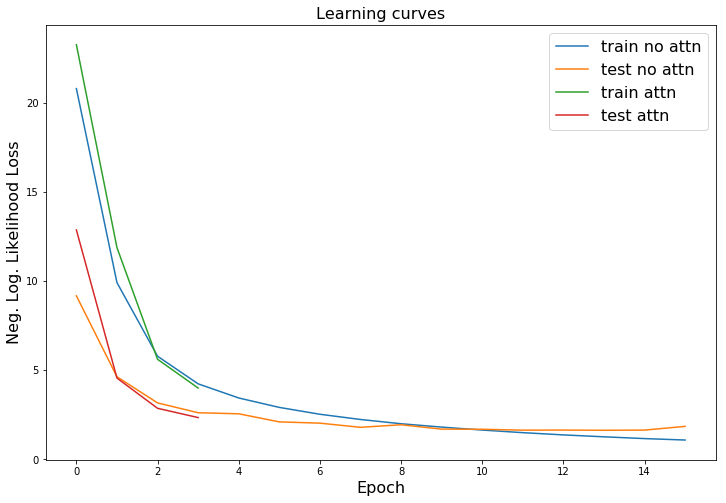

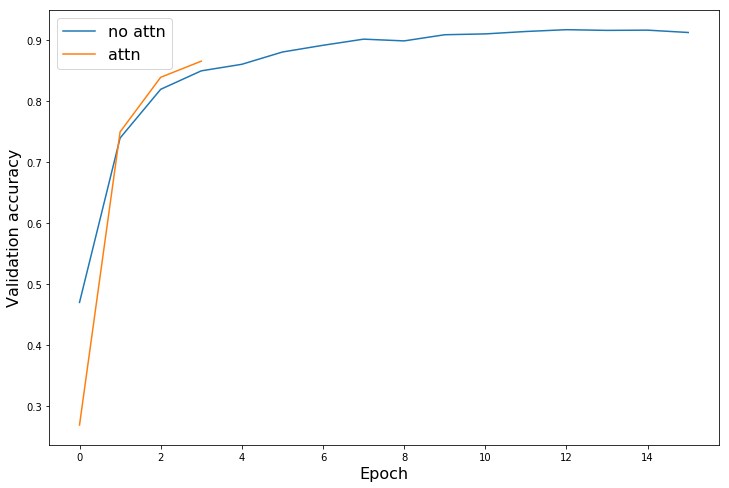

In [22]:
def get_data(path):
    epoch = []
    train = []
    test = []
    acc = []
    
    with open(path, 'r') as f:
        for line in f:
            data = list(map(float, line.split()))
            epoch.append(data[0])
            train.append(data[1])
            test.append(data[2])
            acc.append(data[3])
        
    return epoch, train, test, acc

plt.figure(figsize=(12, 8))

for path in paths_to_data:
    epoch, loss_train, loss_test, acc_test = get_data(path[0])
    plt.plot(epoch, np.array(loss_train), label='train '+path[2])
    plt.plot(epoch, loss_test, label='test '+path[2])
    plt.ylabel("Neg. Log. Likelihood Loss", fontsize=16)
    plt.xlabel("Epoch", fontsize=16)
    plt.title('Learning curves', fontsize=16)
    plt.legend(fontsize=16)

plt.figure(figsize=(12, 8))    

for path in paths_to_data:
    epoch, loss_train, loss_test, acc_test = get_data(path[0])
    plt.plot(epoch, acc_test, label=''+path[2])
    plt.ylabel("Validation accuracy", fontsize=16)
    plt.xlabel("Epoch", fontsize=16)
    plt.legend(fontsize=16)

# Examples (only for net with attention)

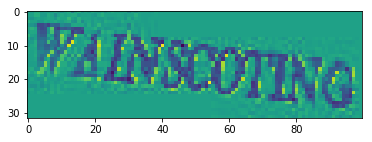

Predicted: vainscoting


In [23]:
transform = transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

encoder = attn.models.CNN(imgH, input_channels, nh)
decoder = attn.models.AttentionDecoder(nh, nclass, max_length=max_width)

test_dataset = WordImageDataset(root_dir, "annotation_test_new.txt", alphabet, transform, max_samples=5000)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

for path in [("./attn/learning_curves_attn.txt", "./attn/run1", "attn")]:
    epoch, loss_train, loss_test, acc_test = get_data(path[0])
   
    best_epoch = np.argmax(acc_test)
    enc_path = '{}/encoder_{}.pth'.format(path[1], int(epoch[best_epoch]))
    dec_path = '{}/decoder_{}.pth'.format(path[1], int(epoch[best_epoch]))
    encoder.load_state_dict(torch.load(enc_path))
    decoder.load_state_dict(torch.load(dec_path))
    
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    images, texts = next(iter(test_loader))
    b = images.size(0)
    #print(images.size())
    images = images.to(device)
    target_variable = converter.encode(texts).to(device)

    decoded_words = []
    decoded_label = []
    decoder_attentions = torch.zeros(len(texts[0]) + 1, max_width)
    
    encoder_outputs = encoder(images)
    decoder_input = target_variable[0].to(device)
    decoder_hidden = decoder.initHidden(b).to(device)

    for di in range(1, target_variable.shape[0]):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)

        decoder_attentions[di-1] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi.squeeze(1)
        decoder_input = ni

        if ni == 1:
            decoded_words.append('<EOS>')
            decoded_label.append(1)
            break
        else:
            decoded_words.append(converter.decode(ni))
            decoded_label.append(ni)
        
    plt.imshow(images.cpu().view(32, 100).numpy())
    plt.show()
    print("Predicted: {}".format("".join(decoded_words[:-1])))

# Skoltech

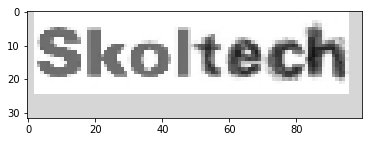

Predicted: skoltech


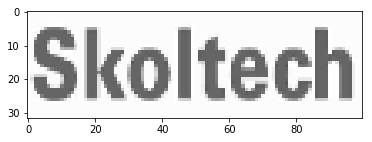

Predicted: skoltech


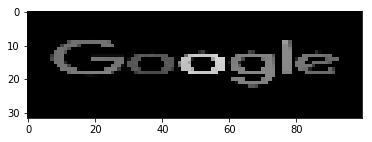

Predicted: crogle


In [24]:
def predict_image(image_path, encoder, decoder, device):
    img = Image.open(image_path).resize((100, 32)).convert('L')
    img_t = torch.tensor([np.array(img)], dtype=torch.float32, device=device).unsqueeze(0)

    decoded_words = []
    decoded_label = []

    encoder_outputs = encoder(img_t)
    decoder_input = target_variable[0].to(device)
    decoder_hidden = decoder.initHidden(b).to(device)

    for di in range(1, target_variable.shape[0]):
        decoder_output, decoder_hidden, _ = decoder(
            decoder_input, decoder_hidden, encoder_outputs)

        topv, topi = decoder_output.data.topk(1)
        ni = topi.squeeze(1)
        decoder_input = ni

        if ni == 1:
            decoded_words.append('<EOS>')
            decoded_label.append(1)
            break
        else:
            decoded_words.append(converter.decode(ni))
            decoded_label.append(ni)
        
    plt.imshow(img)
    plt.show()
    print("Predicted: {}".format("".join(decoded_words[:-1])))

predict_image('./examples/skolkovo.png', encoder, decoder, device)
predict_image('./examples/skoltech.jpg', encoder, decoder, device)
predict_image('./examples/google.png', encoder, decoder, device)